
```

# SENTIMENT ANALYSIS
 

**For this sentiment analysis task, one of the methods for count vectorizing is that bag of words(bow) is used. Also for the parf of ML,
KNN is implemented from scratch. I wrote a train_test_split function instead of using sklearn.model_selection library. In my function, corpus is shuffled randomly every time it run. Because of that accuracy may change. I saw 70% as maximum. Then I compared the accuracy with SVM using library. I saw the accuracy around 40%. My result looked like better than it. Infact it's pretty low since there is no lemmetization or stemming.
It can be fixed.** 


In [2]:
import io, os
import re as re
import zipfile as zipfile
import numpy as np
film_yorumlari =[]
labels=[]
def read_file(zipname):
    
    with zipfile.ZipFile(zipname) as z:
      for zipinfo in z.infolist() :
        if zipinfo.filename.endswith('.txt')and re.search('raw_texts/', zipinfo.filename):
            labels.append(zipinfo.filename.split("/")[2])
            with open(zipinfo.filename,"r") as f:
                film_yorumlari.append(f.read())
    return film_yorumlari,labels

film_yorumlari,labels = read_file('film_yorumlari.zip')

FileNotFoundError: [Errno 2] No such file or directory: 'film_yorumlari.zip'

In [41]:
labels = np.asarray([0 if label=="negatif" else 1 if label=="pozitif" else 2 for label in labels]
                  ).reshape(-1,1)# list comprehensions for labels


In [42]:
def get_tokenize(text):        
    acronym_each_dot = r"(?:[a-zğçşöüı]\.){2,}"
    acronym_end_dot = r"\b[a-zğçşöüı]{2,3}\."
    suffixes = r"[a-zğçşöüı]{3,}' ?[a-zğçşöüı]{0,3}"
    numbers = r"\d+[.,:\d]+"
    any_word = r"[a-zğçşöüı]+"
    punctuations = r"[a-zğçşöüı]*[.,!?;:]"
    word_regex = "|".join([acronym_each_dot,
                           acronym_end_dot,
                           suffixes,
                           numbers,
                           any_word,
                           punctuations])    
    return re.compile("%s"%word_regex, re.I).findall(text)

In [43]:
stopwords= frozenset(["acaba","ama","ancak","arada","bana","belki","ben","benden",
                         "beni","bence","benim","beri","bile","bi","bin","bir","biraz","biri","birkez",
                         "biz","bize","bizden","bizim","böyle","bu","buna","bunda","bundan",
                         "bunlar","bunu","bunun","burada","çok","da","daha","dahi","de","değil","defa",
                         "diye","doksan","edecek","eden","ederek","edilecek","ediliyor",
                         "ediyor","elli","en","etmesi","etti","fakat","gibi","halen","hangi",
                         "hatta","hem","hep","hepsi","her","herhangi","herkesin","için","iki",
                         "ile","ilgili","ise","itibaren","itibariyle","kadar","kendi",
                         "kendilerine","kendini","kendisi","kendisine","kez","ki","kim",
                         "kimden","kime","kimi","kimse","milyar","milyon","mu","ne",
                         "neden","nedenle","nerde","nerede","nereye","niye","olan",
                         "olarak","oldu","olduğu","olduğunu","olmuş","olmak","olmayan","olmaz","olsa","olsun",
                         "olup","olur","olursa","oluyor","on","ona","ondan","onlar",
                         "onlardan","onu","onun","oysa","öyle","pek","sadece","sanki","sekiz",
                         "sen","senden","seni","senin","siz","sizden","sizi","sizin","sonra","şey","tam","tek","tüm",
                         "var","var.","ve","veya","ya","yani","yapacak","yapmak","yapılmış","yok","yok.","yine","yoksa",
                         "zaten",".",",",":",";","?","!","i","o"])

In [44]:
def clean_text():
    cleaned_text = []
    for yorum in film_yorumlari:
        yorum = yorum.lower()
        yorum = get_tokenize(yorum)
        yorum = [y for y in yorum if not y in stopwords]
        yorum =" ".join(yorum)
        cleaned_text.append(yorum) 
    return cleaned_text
cleaned_text = clean_text()
del(film_yorumlari)

In [45]:
def create_word_freq(corpus,n):
    word_freq = dict()
    for document in corpus:    
        tokens = get_tokenize(document)
        for token in tokens:
            if token in word_freq.keys():
                word_freq[token] +=1        
            else:
                word_freq[token]=1  
    most_freq = sorted(word_freq.items(),key=lambda x:x[1],reverse=True)
    return dict(most_freq[:n])

most_freq =create_word_freq(cleaned_text,30)

In [46]:
def create_bow(corpus):  
    sentence_vectors = []
    for document in corpus:
        sentence_tokens = get_tokenize(document)
        sent_vec=[]
        for token in most_freq:        
            if token in sentence_tokens:
                sent_vec.append(1)
            else:
                sent_vec.append(0)   
        sentence_vectors.append(sent_vec)
    sentence_vectors = np.asarray(sentence_vectors)
    return sentence_vectors

bow = create_bow(cleaned_text)


In [49]:
def train_test_split(x,y,test_size):
    xy = np.concatenate((x,y),axis=1)
    np.random.shuffle(xy)
    test_size = test_size*x.shape[0]
    
    x = xy[...,:-1]
    y = xy[...,-1]
    
    x_train = x[int(test_size):]
    x_test  = x[:int(test_size)]
    y_train = y[int(test_size):].reshape(-1,1)
    y_test  = y[:int(test_size)].reshape(-1,1)
    
    return x_train,x_test,y_train,y_test
#%%
x_train,x_test,y_train,y_test = train_test_split(bow,labels,test_size=0.2)


In [50]:
def euclidean_distance(x1, x2):   
        return np.sqrt(np.sum((x1 - x2)**2))
    
def _predict(x_test,k):
    
    distances= [euclidean_distance(x_test, x_) for x_ in x_train]
    distances = np.asarray(distances)
    k_indexs = np.argsort(distances)[:k]
    k_neighbours_labels = [y_train[i] for i in k_indexs] 
    counts=dict()
    for i in k_neighbours_labels:
        for j in i:
            if j in counts.keys():
                counts[j]+=1
            else:
                counts[j]=1
    most_freq = sorted(counts.items(),key=lambda x:x[1],reverse=True)
    return most_freq[0][0]

def predict(test,k):   
    predictions=[]
    for i in test:   
        predictions.append(_predict(i,k))       
    return np.array(predictions)


In [51]:
predictions = predict(x_test,17).reshape(-1,1)
accuracy  = np.sum(y_test == predictions)/len(y_test)*100
print(accuracy)

38.095238095238095


In [52]:
#Implementing score list for k neighbour between 1 and 30.
score_list = []
for each in range(1,30):        
    prediction =predict(x_test,each).reshape(-1,1)
    accuracy  = np.sum(y_test == prediction)/len(y_test)*100  
    score_list.append(accuracy)
best_knn_value = score_list.index(max(score_list))+1
print(f"Best KNN Value : {best_knn_value}")


Best KNN Value : 3


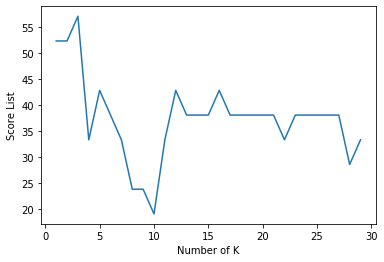

In [53]:
import matplotlib.pyplot as plt
plt.plot([each for each in range(1,30)],score_list)
plt.xlabel("Number of K")
plt.ylabel("Score List")
plt.show()

In [54]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,y_train)

y_predict_lr=lr.predict(x_test).reshape(-1,1)
accuracy  = np.sum(y_test == y_predict_lr)/len(y_test)*100
print(f"accuracy is :{accuracy} ")

accuracy is :42.857142857142854 


C:\Users\Ogi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
